In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import math as m
import scipy.fftpack
from scipy.signal import find_peaks
import statistics as st

## Analysis of the frequency of STOs as a function of temperature, in IO single cell models  
  
7 cells were analysed, indicated by the letter "C" followed by a number and possibly a letter.  
Characteristics of the simulation corresponding to the analysed dataset can be found in *SimulationResults\datasets.xls*.  
Each dataset contains voltage traces of one cell, measured at the soma, at various temperatures.  

### Peak detection  
First, the frequency of the STOs at all temperatures is determined for all datasets using peak detection.  
The results are stored in the dictionary `freqs_dict`. 

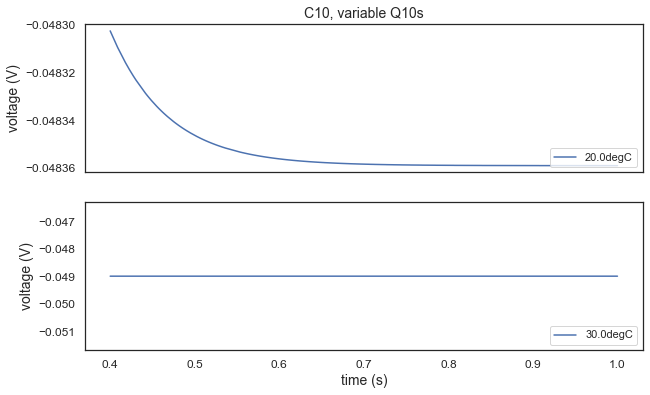

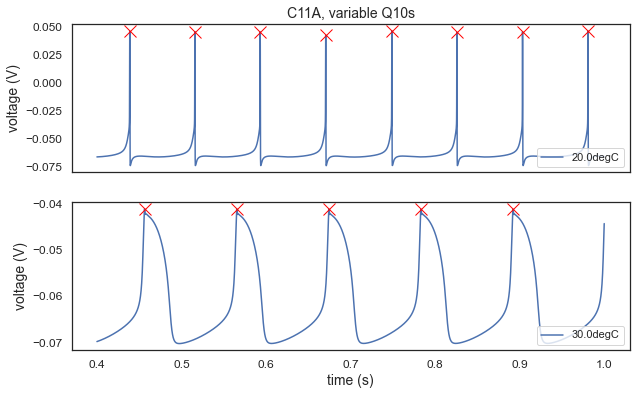

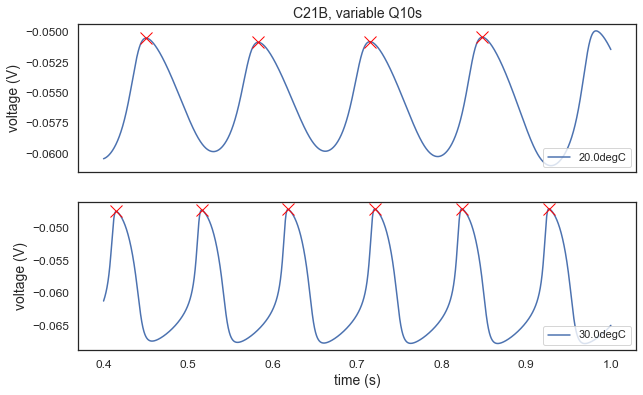

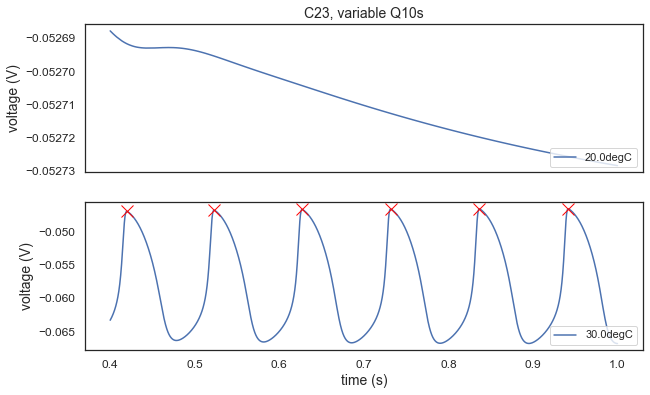

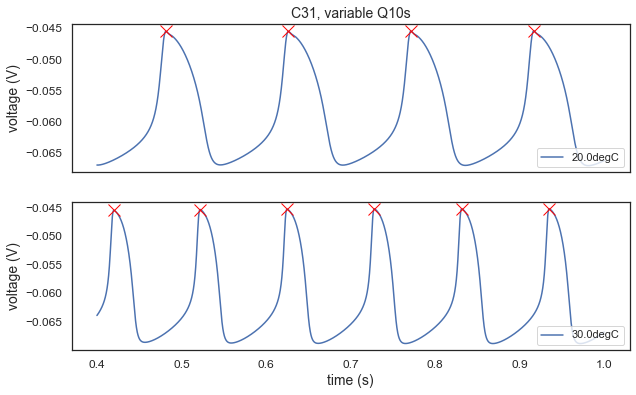

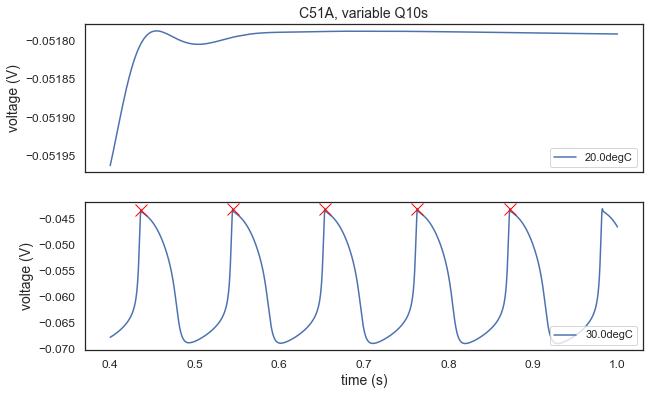

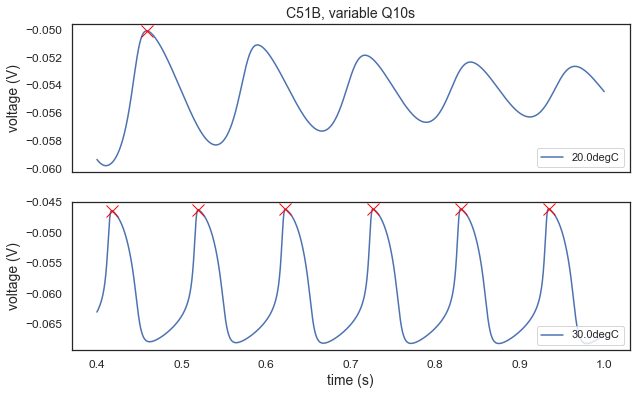

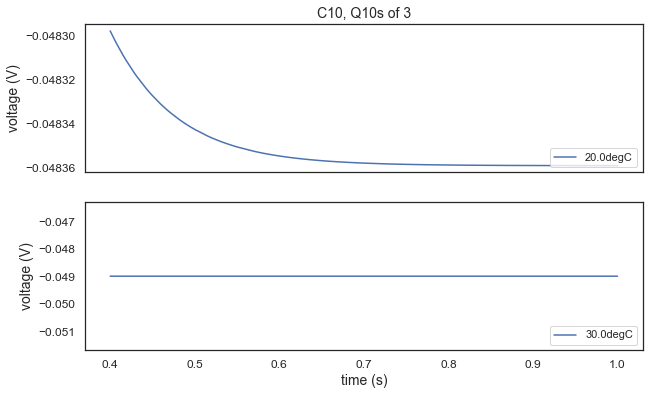

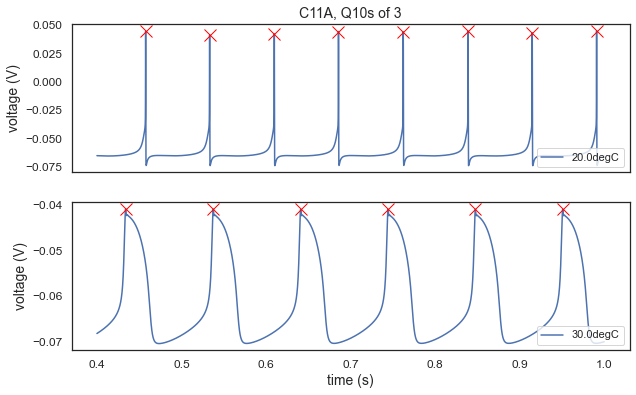

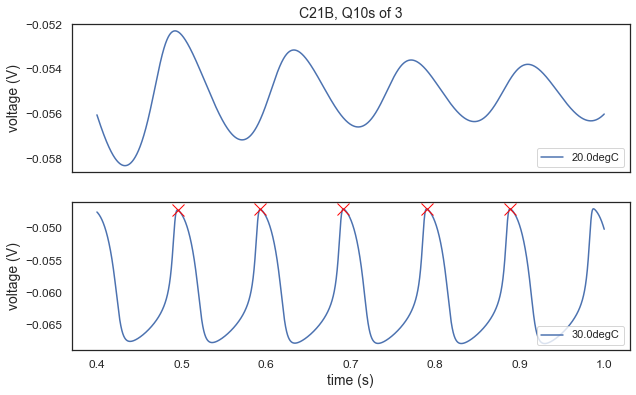

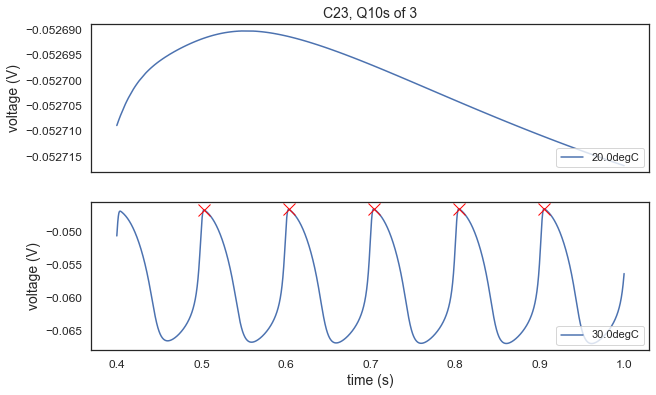

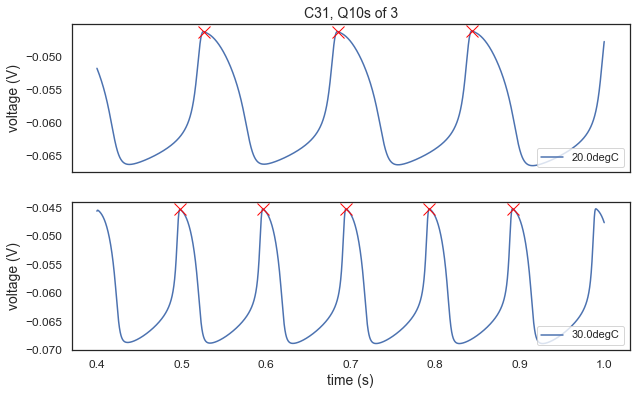

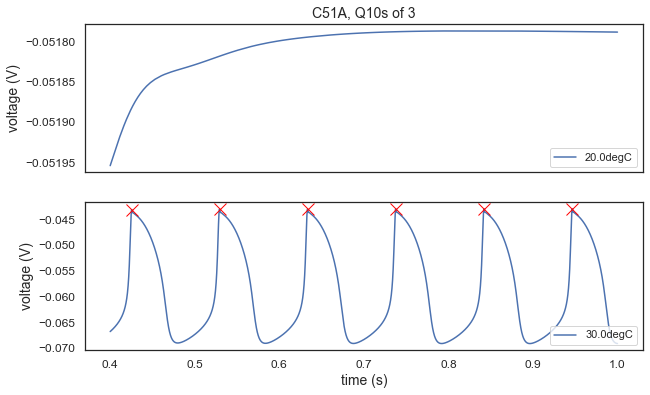

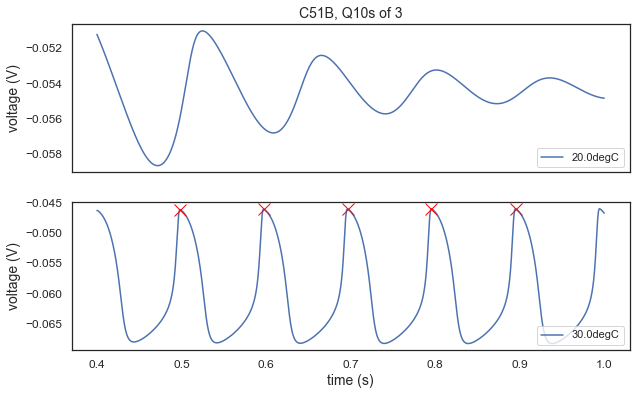

In [17]:
cellNames = ["7_C10", "7_C11A", "7_C21B", "7_C23", "7_C31", "7_C51A", "7_C51B",
              "8_C10", "8_C11A", "8_C21B", "8_C23", "8_C31", "8_C51A", "8_C51B"]

plot = True
cells_to_plot = ["C10", "C11A", "C21B", "C23", "C31", "C51A", "C51B"]

temps_to_plot = [20, 30] #always pick at least 2

freqs_dict = {}

for cellName in cellNames:
    data_set = pd.read_csv("SimulationResults/"+cellName+".csv", index_col=0)
    data_set = data_set.drop(data_set.loc[:, '0':'0.3999'].columns, axis = 1) 
    data_setT = data_set.transpose()
    
    freqs = []
    N = data_set.shape[0]

    t = []
    for i in list(data_set.iloc[0].index.values):
        t.append(float(i))
    
    if plot and cellName[2:] in cells_to_plot: 
        nr_subplots = len(temps_to_plot)
        fig, ax = plt.subplots(nr_subplots, 1, figsize = (10, 3*nr_subplots))
        window = 0
    
    for temp_ind in range(N):
        data = data_setT.iloc[:, temp_ind]
        peaks, _ = find_peaks(data, prominence = 0.008)
        if len(peaks) > 2:
            freq = (len(peaks) - 1)/(t[peaks[-1]] - t[peaks[0]])
            freqs.append(freq)
        else:
            freqs.append(0)
        if plot and cellName[2:] in cells_to_plot and temp_ind/10 + 20 in temps_to_plot:
            ax[window].plot(t, data.values)
            if window == nr_subplots-1:
                ax[window].set_xlabel('time (s)', fontsize=14)
            if window != nr_subplots-1:
                ax[window].set_xticks([])
            ax[window].set_ylabel('voltage (V)', fontsize=14)
            ax[window].legend([data_setT.columns[temp_ind]], loc = 'lower right')
            for i in peaks:
                ax[window].plot(t[i], data.values[i],'x', color = 'red', markersize = 12)
            if cellName[0] == "7" and window == 0:
                ax[window].set_title(cellName[2:]+", variable Q10s", fontsize=14)
            if cellName[0] == "8" and window == 0:
                ax[window].set_title(cellName[2:]+", Q10s of 3", fontsize=14)

            window += 1
            
    freqs_dict[cellName] = freqs
    plt.show()

### Plotting the results  
Next, the frequency of oscillation as a function of temperature can be plotted for the different cells. 

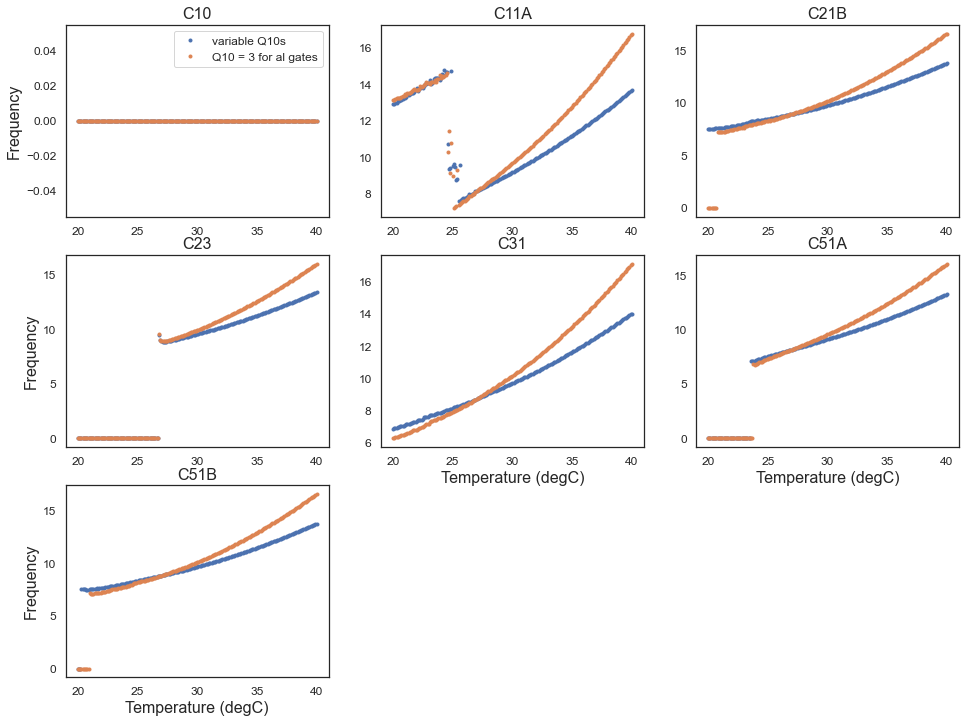

In [5]:
ran2 = range(200,401)
temps = []
for i in range(len(ran2)):
    temps.append(ran2[i]/10)

n = m.ceil(m.sqrt(len(freqs_dict.keys())/2))
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

window = 1

fig = plt.figure()

cellNames = ["C10", "C11A", "C21B", "C23", "C31", "C51A", "C51B"]
for cellName in cellNames:
    ax = fig.add_subplot(n, n, window)
    ax.plot(temps, freqs_dict["7_"+cellName], '.')
    ax.plot(temps, freqs_dict["8_"+cellName], '.')
    if window > len(cellNames)-n:
        plt.xlabel('Temperature (degC)', fontsize=16)
    if int((window ) % 3) == 1:
        plt.ylabel('Frequency', fontsize=16)
    if window == 1:
        plt.legend(['variable Q10s','Q10 = 3 for al gates'], fontsize=12)
        
    plt.title(cellName, fontsize=16)
    
    window += 1

plt.show()

We can distinguish 4 types of behaviour: 
- C10 is silent over the whole temperature range considered here.
- The plot corresponding to C11A is composed of two discontinuous parts, both going up with temperature. At the discontinuity, some "randomly" scattered points are visible. We will come back to this cell later. 
- C31 (and C21B modelled with variable Q10s) has a frequency of oscillation that increases smoothly with temperature
- All other cells show a transition from silent to oscillating behavior. At the point of transition, a jump in the frequency is observed: all cells have a starting frequency > 0. This starting frequency seems to be around 7 for all cells, the temperature at which the cells start oscillating differs more between cells. We will look more into this in the next cell/section. 

The most significant difference between the models with variable Q10s and the models with Q10s of 3 is the steepness of the curves. The orange curves are steeper for all cells, except for the left part of the curve corresponding to cell C11A. This can be explained by the fact that the Q10s in the set of variable Q10s were on generally lower than 3, hence in these models temperature has less effect on the results. Again, cell C11A will be discussed later in this document.

It is likely that cell C31 will also go silent or show similar behavior to cell C10 if we simulate it at lower temperatures. However, modelling temperature dependence to be linear (as we do when considering fixed Q10 values) is only reasonable within a certain range of temperatures. Most of the ones we found in literature (see document *overview_conductances.xls*) were valid within a range of approximately 23-30 degrees Celsius. Thus, our range of 20-40 degrees Celsius is already quite high. Therefore, we chose not to consider lower temperatures for this cell. 

### Quantifying the bifurcation in cell C21B, C23, C31, C51A and C51B  

We will now determine the bifurcation temperature, the steepness of the frequency incresase after the bifurcation and the starting frequency for the 5 cells stated above.  

The curves are better described by a quadretic fit than a linear fit. However, since (in our situation) the steepness of a linear fit is way easier to interpret than the parameters of a quadretic fit, we chose to summarize the trend by its linear fit (and thus by its starting point and steepness).

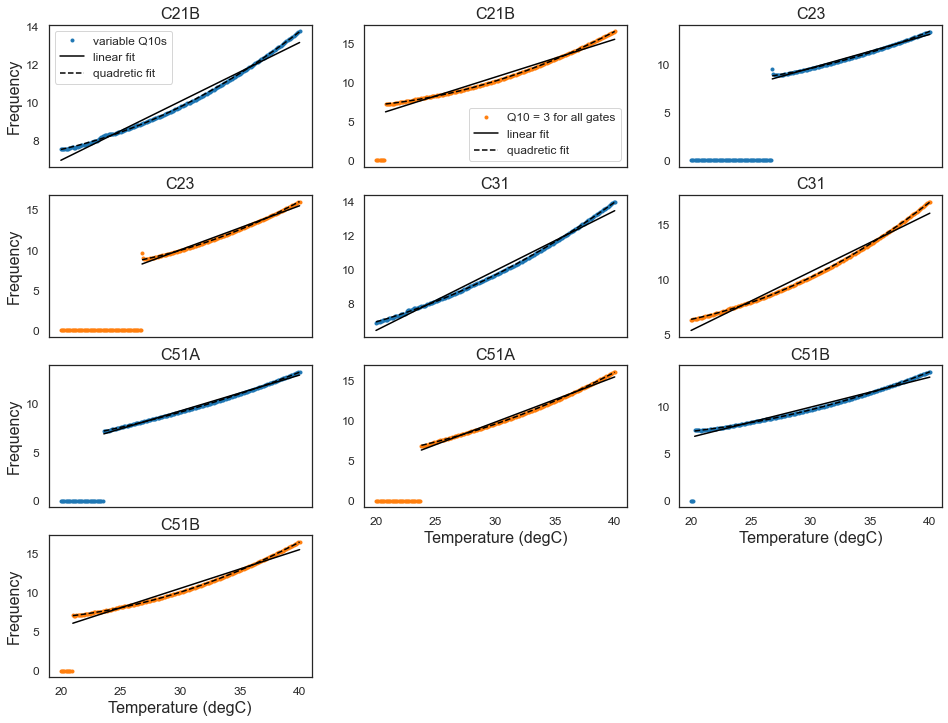

  cellName  startFreq [Hz]  steepness [Hz/degC]  bifTemp [degC]
0   7_C21B        7.545272             0.311433             NaN
1   8_C21B        7.213272             0.486497            20.8
2    7_C23        9.507963             0.352712            26.8
3    8_C23        9.610764             0.549960            26.8
4    7_C31        6.894967             0.351954             NaN
5    8_C31        6.299213             0.533965             NaN
6   7_C51A        7.163324             0.370815            23.6
7   8_C51A        6.856359             0.564700            23.8
8   7_C51B        7.575758             0.320144            20.3
9   8_C51B        7.173601             0.498157            21.0


In [18]:
cellNames = ["C21B", "C23", "C31", "C51A", "C51B"]
bif_temp = {}
startFreq = {}
steepness = {}
temps_dict = {}

freqs_dict_no0 = freqs_dict.copy()

fig = plt.figure()
window = 1

for cellName in cellNames:
    for nr in [7,8]:
        if freqs_dict[str(nr)+"_"+cellName][0] != 0:
            bif_temp[str(nr)+"_"+cellName] = float('nan')
            temps_dict[str(nr)+"_"+cellName] = temps
            startFreq[str(nr)+"_"+cellName] = freqs_dict[str(nr)+"_"+cellName][0]
        else:
            temps_no0 = temps.copy()
            i = 0
            while freqs_dict[str(nr)+"_"+cellName][i] < 1:
                freqs_dict_no0[str(nr)+"_"+cellName] = freqs_dict_no0[str(nr)+"_"+cellName][1:]
                temps_no0 = temps_no0[1:] 
                i += 1
            bif_ind = i
            startFreq[str(nr)+"_"+cellName] = freqs_dict[str(nr)+"_"+cellName][bif_ind]
            bif_temp[str(nr)+"_"+cellName] = temps[bif_ind]
            temps_dict[str(nr)+"_"+cellName] = temps_no0
     
        p1 = np.polyfit(temps_dict[str(nr)+"_"+cellName], freqs_dict_no0[str(nr)+"_"+cellName], 1)
        p2 = np.polyfit(temps_dict[str(nr)+"_"+cellName], freqs_dict_no0[str(nr)+"_"+cellName], 2)
        fit1 = []
        fit2 = []
        
        steepness[str(nr)+"_"+cellName] = p1[0]
        
        for j in range(len(temps_dict[str(nr)+"_"+cellName])):
            fit1.append(p1[0]*temps_dict[str(nr)+"_"+cellName][j] + p1[1])
            fit2.append(p2[0]*temps_dict[str(nr)+"_"+cellName][j]**2 + p2[1]*temps_dict[str(nr)+"_"+cellName][j] + p2[2])
        
        ax = fig.add_subplot(4, 3, window)
        if window % 2 == 0:
            ax.plot(temps, freqs_dict[str(nr)+"_"+cellName], '.', color = 'tab:orange')
        else: 
            ax.plot(temps, freqs_dict[str(nr)+"_"+cellName], '.', color = 'tab:blue')
                
        ax.plot(temps_dict[str(nr)+"_"+cellName], fit1, '-', color = 'black')
        ax.plot(temps_dict[str(nr)+"_"+cellName], fit2, '--', color = 'black')
        
        if window > len(cellNames)*2-3:
            plt.xlabel('Temperature (degC)', fontsize=16)
        if int((window ) % 3) == 1:
            plt.ylabel('Frequency', fontsize=16)
        if window <= len(cellNames)*2-3:
            plt.xticks([])
        if window == 1 or window == 2:
            if window % 2 == 0:
                plt.legend(["Q10 = 3 for all gates", "linear fit", "quadretic fit"], fontsize=12)  
            else: 
                plt.legend(["variable Q10s", "linear fit", "quadretic fit"], fontsize=12)
        plt.title(cellName, fontsize=16)
    
        window += 1

plt.show()

table = pd.DataFrame(list(startFreq.items()),columns = ['cellName','startFreq [Hz]']) 
tableTemp1 = pd.DataFrame(list(steepness.items()),columns = ['cellName','steepness [Hz/degC]']) 
tableTemp2 = pd.DataFrame(list(bif_temp.items()),columns = ['cellName','bifTemp [degC]']) 
table['steepness [Hz/degC]'] = tableTemp1['steepness [Hz/degC]']
table['bifTemp [degC]'] = tableTemp2['bifTemp [degC]']
print(table)

### Cell C11A: spiking and STOs

We now look into cell C11A more closely. We want to know what is happening at low temperatures. When looking again at the plots in the first cell of this document, we see that at low temperatures, C11A does not show STOs, but instead produces simple spikes. The bifurcation point is the moment when spiking turns to oscillation and the points in between the two smooth parts correspond to some transition state in which we see spikes and STOs alternating.  

We can now again compute the bifurcation temperature and the starting point and steepness of the frequency of the STOs. Moreover, we can determine the starting point and steepness of the spiking frequency. 

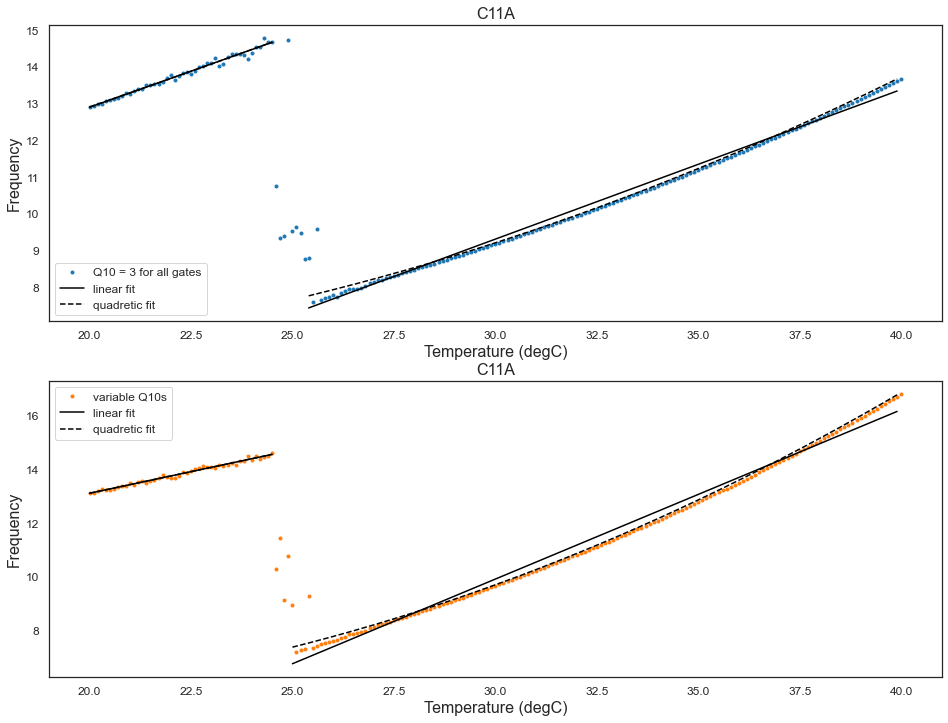

                           cellName     7_C11A     8_C11A
0            spiking startFreq [Hz]  12.915129  13.123360
1  spiking freq steepness [Hz/degC]   0.392537   0.320661
2                    bifTemp [degC]  24.900000  24.700000
3             sto startingFreq [Hz]   7.600228   7.216743
4      sto freq steepness [Hz/degC]   0.407238   0.628417


In [40]:
cellNames = ["C11A"]
bif_temp = {}
spiking_dict = {}
transition_dict = {}
sto_dict = {}

fig = plt.figure()
window = 1

for cellName in cellNames:
    for nr in [7,8]:
        i = 1
        spiking = []
        transition = []
        sto = []
        spiking_temp = []
        transition_temp = []
        sto_temp = []
        
        while abs(freqs_dict[str(nr)+"_"+cellName][i] - freqs_dict[str(nr)+"_"+cellName][i-1]) < 0.5:
            spiking.append(freqs_dict[str(nr)+"_"+cellName][i-1])
            spiking_temp.append(temps[i-1])
            i += 1
        spiking.append(freqs_dict[str(nr)+"_"+cellName][i-1])
        spiking_temp.append(temps[i-1])
        
        while freqs_dict[str(nr)+"_"+cellName][i] > 8:
            transition.append(freqs_dict[str(nr)+"_"+cellName][i])
            transition_temp.append(temps[i-1])
            i += 1
            
        startFreq[str(nr)+"_"+cellName+"sto"] = freqs_dict[str(nr)+"_"+cellName][i]
        startFreq[str(nr)+"_"+cellName+"spiking"] = freqs_dict[str(nr)+"_"+cellName][0]
        
        while i < len(freqs_dict[str(nr)+"_"+cellName]):
            sto.append(freqs_dict[str(nr)+"_"+cellName][i])
            sto_temp.append(temps[i-1])
            i += 1
            
        spiking_dict[str(nr)+"_"+cellName] = spiking
        transition_dict[str(nr)+"_"+cellName] = transition
        sto_dict[str(nr)+"_"+cellName] = sto
        spiking_dict[str(nr)+"_"+cellName+"temp"] = spiking_temp
        transition_dict[str(nr)+"_"+cellName+"temp"] = transition_temp
        sto_dict[str(nr)+"_"+cellName+"temp"] = sto_temp
    
        p1_spiking = np.polyfit(spiking_dict[str(nr)+"_"+cellName+"temp"], spiking_dict[str(nr)+"_"+cellName], 1)
        p2_spiking = np.polyfit(spiking_dict[str(nr)+"_"+cellName+"temp"], spiking_dict[str(nr)+"_"+cellName], 2)
        p1_sto = np.polyfit(sto_dict[str(nr)+"_"+cellName+"temp"], sto_dict[str(nr)+"_"+cellName], 1)
        p2_sto = np.polyfit(sto_dict[str(nr)+"_"+cellName+"temp"], sto_dict[str(nr)+"_"+cellName], 2)
        
        fit1_spiking = []
        fit2_spiking = []
        fit1_sto = []
        fit2_sto = []
        
        steepness[str(nr)+"_"+cellName+"spiking"] = p1_spiking[0]
        steepness[str(nr)+"_"+cellName+"sto"] = p1_sto[0]
        
        for j in range(len(spiking_dict[str(nr)+"_"+cellName+"temp"])):
            fit1_spiking.append(p1_spiking[0]*spiking_dict[str(nr)+"_"+cellName+"temp"][j] + p1_spiking[1])
            fit2_spiking.append(p2_spiking[0]*spiking_dict[str(nr)+"_"+cellName+"temp"][j]**2 + 
                        p2_spiking[1]*spiking_dict[str(nr)+"_"+cellName+"temp"][j] + p2_spiking[2])
        
        for j in range(len(sto_dict[str(nr)+"_"+cellName+"temp"])):
            fit1_sto.append(p1_sto[0]*sto_dict[str(nr)+"_"+cellName+"temp"][j] + p1_sto[1])
            fit2_sto.append(p2_sto[0]*sto_dict[str(nr)+"_"+cellName+"temp"][j]**2 + 
                        p2_sto[1]*sto_dict[str(nr)+"_"+cellName+"temp"][j] + p2_sto[2])
        
        ax = fig.add_subplot(2, 1, window)
        if window % 2 == 0:
            ax.plot(temps, freqs_dict[str(nr)+"_"+cellName], '.', color = 'tab:orange')
        else: 
            ax.plot(temps, freqs_dict[str(nr)+"_"+cellName], '.', color = 'tab:blue')
                
        ax.plot(spiking_dict[str(nr)+"_"+cellName+"temp"], fit1_spiking, '-', color = 'black')
        ax.plot(spiking_dict[str(nr)+"_"+cellName+"temp"], fit2_spiking, '--', color = 'black')
        
        ax.plot(sto_dict[str(nr)+"_"+cellName+"temp"], fit1_sto, '-', color = 'black')
        ax.plot(sto_dict[str(nr)+"_"+cellName+"temp"], fit2_sto, '--', color = 'black')
        
        plt.xlabel('Temperature (degC)', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        if window == 1:
            plt.legend(["Q10 = 3 for all gates", "linear fit", "quadretic fit"], fontsize=12)  
        else: 
            plt.legend(["variable Q10s", "linear fit", "quadretic fit"], fontsize=12)
        plt.title(cellName, fontsize=16)
    
        window += 1

plt.show()

transition_temp = {}
for cellName in cellNames:
    for nr in [7,8]:
        transition_temp[str(nr)+"_"+cellName+"mean"] = st.mean(transition_dict[str(nr)+"_"+cellName+"temp"])
        transition_temp[str(nr)+"_"+cellName+"std"] = st.pstdev(transition_dict[str(nr)+"_"+cellName+"temp"])

output_dict = {}
output_dict['cellName'] = ['spiking startFreq [Hz]','spiking freq steepness [Hz/degC]', 
                 'bifTemp [degC]', 'sto startingFreq [Hz]', 'sto freq steepness [Hz/degC]']
output_dict['7_C11A'] = [startFreq['7_C11Aspiking'], steepness['7_C11Aspiking'], 
                        transition_temp['7_C11Amean'], startFreq['7_C11Asto'], steepness['7_C11Asto']]
output_dict['8_C11A'] = [startFreq['8_C11Aspiking'], steepness['8_C11Aspiking'], 
                        transition_temp['8_C11Amean'], startFreq['8_C11Asto'], steepness['8_C11Asto']]
table = pd.DataFrame.from_dict(output_dict) 
print(table)